In [100]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter
from scipy.spatial.distance import cdist

In [101]:
# File paths
locust_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914202153/2023-09-14_20-21-53_VR1_.csv.gz'
environment_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914202153/SimulatedLocustData_SimulatedLocustsVR1_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'

locust_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914202522/2023-09-14_20-25-22_VR1_.csv.gz'
environment_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914202522/SimulatedLocustData_SimulatedLocustsVR1_50_100_180_10000_3_2023-09-14_20-25-22.csv.gz'

#locust_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914203959/2023-09-14_20-39-59_VR1_.csv.gz'
#environment_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914203959/SimulatedLocustData_SimulatedLocustsVR1_50_100_0_10000_3_2023-09-14_20-39-59.csv.gz'

#locust_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914204159/2023-09-14_20-41-59_VR1_.csv.gz'
#environment_file_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914204159/SimulatedLocustData_SimulatedLocustsVR1_50_100_0_0_3_2023-09-14_20-41-59.csv.gz'
# Load the locust data
with gzip.open(locust_file_path, 'rb') as f:
    locust_df = pd.read_csv(f)

# Load the environment data
with gzip.open(environment_file_path, 'rb') as f:
    environment_df = pd.read_csv(f)

# Show first few rows of each dataframe
locust_df.head(), environment_df.head()


(              Current Time   VR             Scene  SensPosX  SensPosY  \
 0  2023-09-14 20:25:22.883  VR1  SimulatedLocusts  0.000000  0.000000   
 1  2023-09-14 20:25:22.899  VR1  SimulatedLocusts  8.322445 -9.933730   
 2  2023-09-14 20:25:22.916  VR1  SimulatedLocusts  8.321234 -9.933030   
 3  2023-09-14 20:25:22.934  VR1  SimulatedLocusts  8.321660 -9.937394   
 4  2023-09-14 20:25:22.950  VR1  SimulatedLocusts  8.324431 -9.936156   
 
    SensPosZ  SensRotX  SensRotY  SensRotZ  InsectPosX  InsectPosY  InsectPosZ  \
 0         0         0    0.0000         0    0.000000           0    0.000000   
 1         0         0  240.6310         0   -9.933730           0    8.322445   
 2         0         0  240.5283         0   -9.933030           0    8.321234   
 3         0         0  240.6571         0   -9.937394           0    8.321660   
 4         0         0  240.5571         0   -9.936156           0    8.324431   
 
    InsectRotX  InsectRotY  InsectRotZ  
 0           0     

In [102]:
#remove first row of locust data
locust_df = locust_df.iloc[1:]

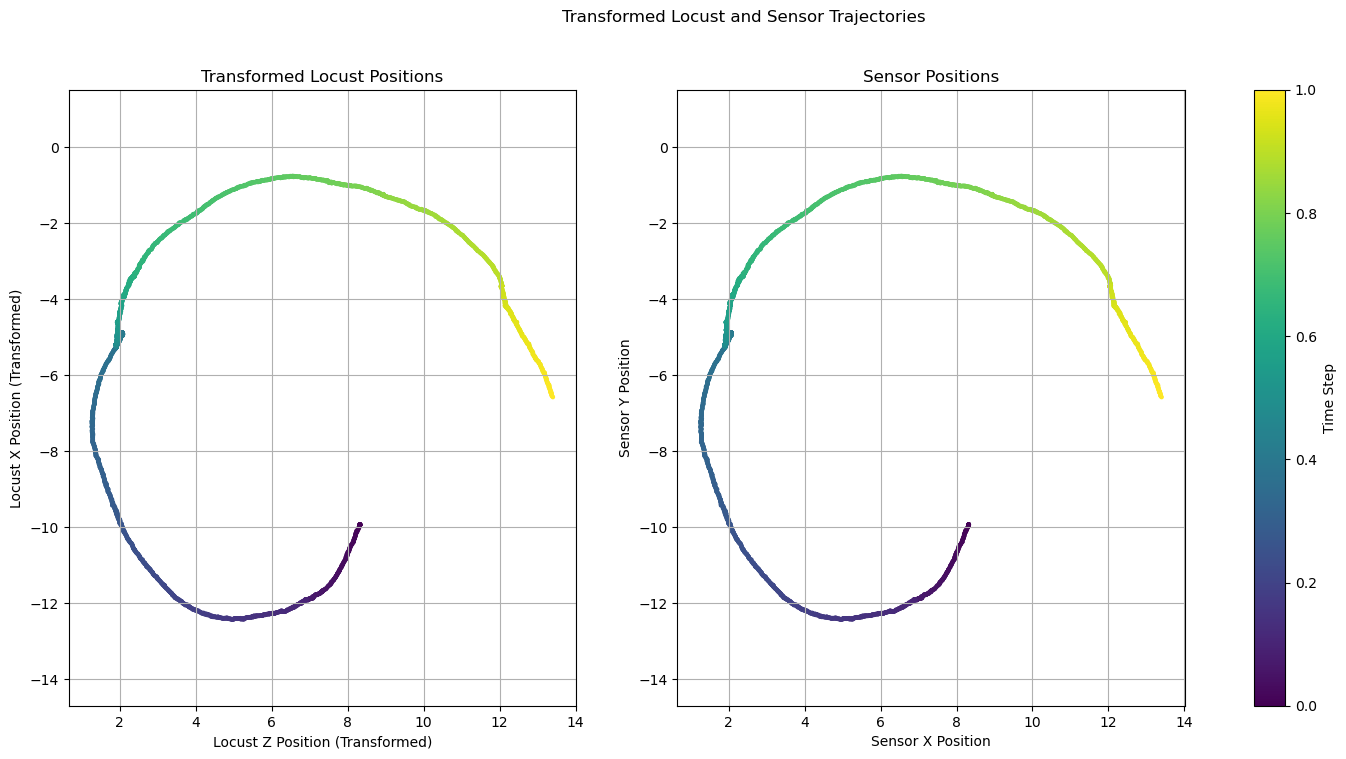

In [103]:
# Creating subplots for locust and sensor trajectories with corrected axes
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Subplot for Transformed Locust Positions (InsectPosZ and InsectPosX)
axes[0].scatter(locust_df['InsectPosZ'], locust_df['InsectPosX'], c=range(len(locust_df)), cmap='viridis', s=5)
axes[0].set_title('Transformed Locust Positions')
axes[0].set_xlabel('Locust Z Position (Transformed)')
axes[0].set_ylabel('Locust X Position (Transformed)')
axes[0].axis('equal')
axes[0].grid(True)

# Subplot for Sensor Positions (SensPosX and SensPosY)
axes[1].scatter(locust_df['SensPosX'], locust_df['SensPosY'], c=range(len(locust_df)), cmap='viridis', s=5)
axes[1].set_title('Sensor Positions')
axes[1].set_xlabel('Sensor X Position')
axes[1].set_ylabel('Sensor Y Position')
axes[1].axis('equal')
axes[1].grid(True)

# Adding colorbar and overall title
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes.ravel().tolist(), label='Time Step')
fig.suptitle('Transformed Locust and Sensor Trajectories')

plt.show()


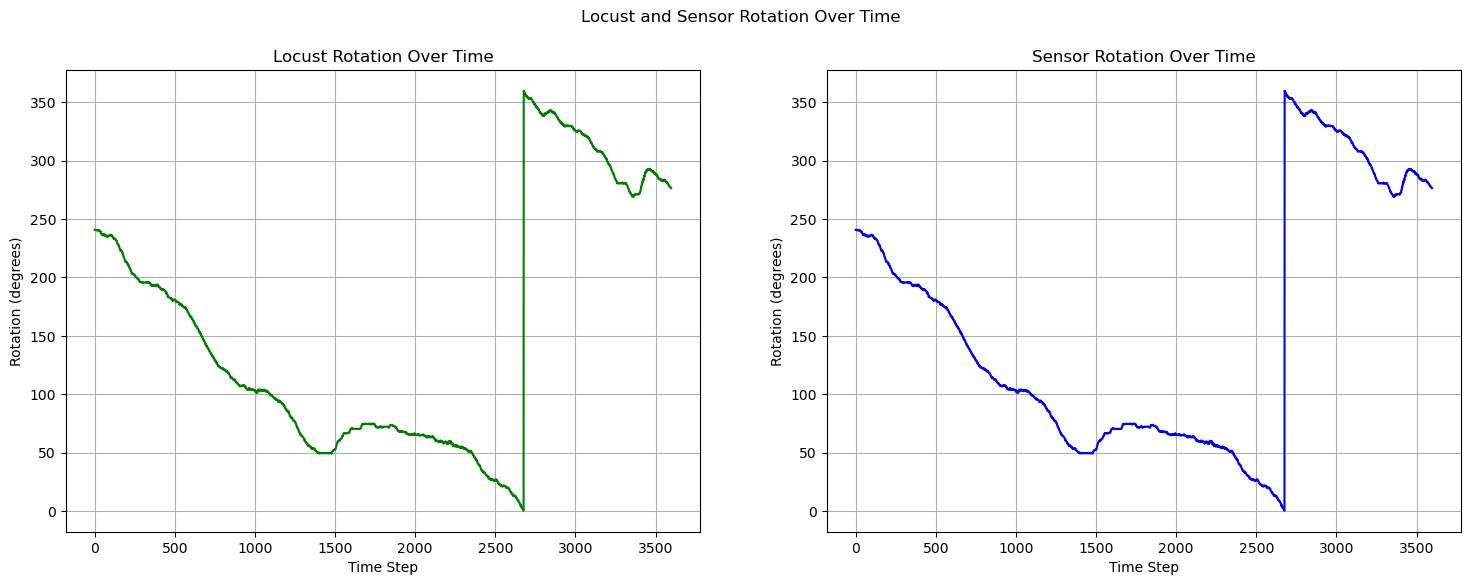

In [104]:
# Creating subplots for locust and sensor rotation over time
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Time index
time_index = range(len(locust_df))

# Subplot for Locust Rotation (InsectRotY)
axes[0].plot(time_index, locust_df['InsectRotY'], color='green', label='Insect Rotation (Y-axis)')
axes[0].set_title('Locust Rotation Over Time')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Rotation (degrees)')
axes[0].grid(True)

# Subplot for Sensor Rotation (SensRotY)
axes[1].plot(time_index, locust_df['SensRotY'], color='blue', label='Sensor Rotation (Y-axis)')
axes[1].set_title('Sensor Rotation Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Rotation (degrees)')
axes[1].grid(True)

# Adding overall title
fig.suptitle('Locust and Sensor Rotation Over Time')

plt.show()

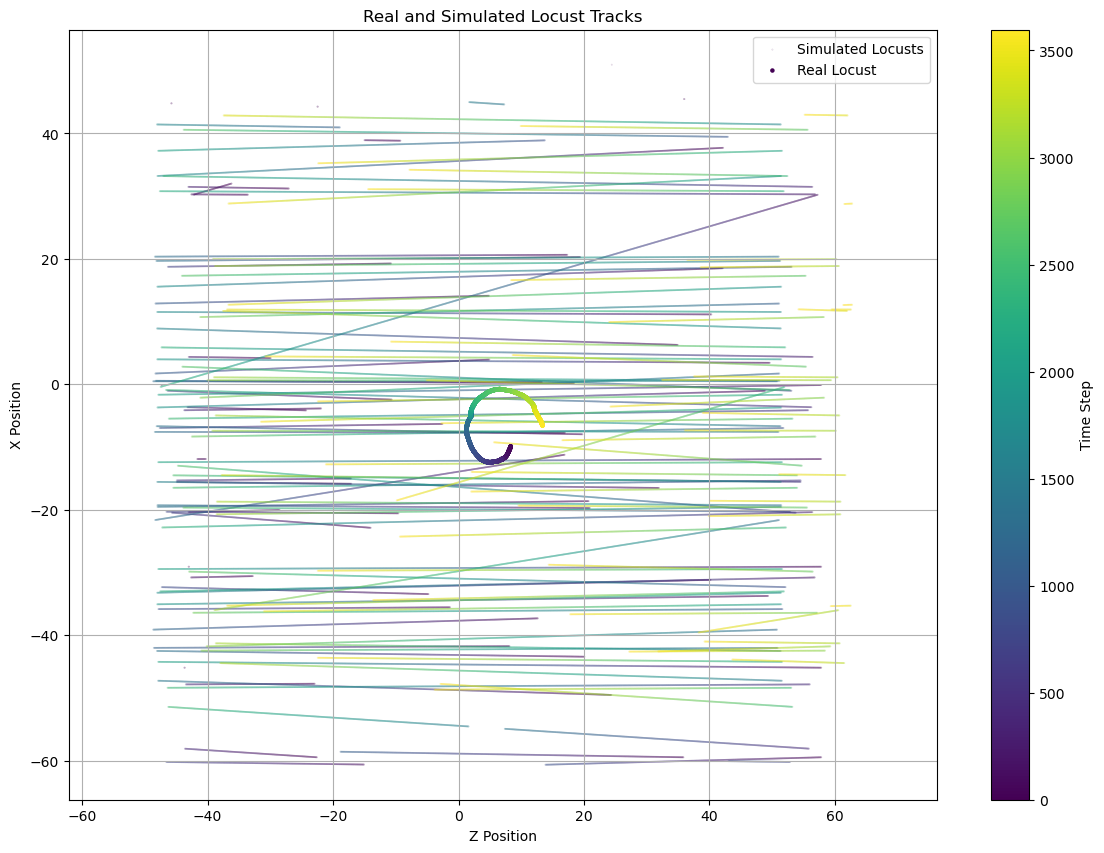

In [105]:
# First, plot the simulated locust positions
plt.figure(figsize=(14, 10))
plt.scatter(environment_df['Z'], environment_df['X'], c=range(len(environment_df)), cmap='viridis', s=0.1, label='Simulated Locusts', alpha = 0.2)

# Next, overlay the real locust trajectory
plt.scatter(locust_df['InsectPosZ'], locust_df['InsectPosX'], c=range(len(locust_df)), cmap='viridis', s=5, label='Real Locust')

# Add colorbar, labels, and title
plt.colorbar(label='Time Step')
plt.title('Real and Simulated Locust Tracks')
plt.xlabel('Z Position')
plt.ylabel('X Position')
plt.grid(True)
plt.legend()

plt.axis('equal')

# Show the plot
plt.show()


In [106]:
# Calculate the differences in x and z positions
dx = locust_df['InsectPosX'].diff()
dz = locust_df['InsectPosZ'].diff()

# Calculate the time difference (assuming constant time step)

# Convert 'Current Time' to datetime format
locust_df['Current Time'] = pd.to_datetime(locust_df['Current Time'])

# Calculate the time difference in seconds
locust_df['dt'] = locust_df['Current Time'].diff().dt.total_seconds()

# Calculate speed
locust_df['Speed'] = np.sqrt(dx**2 + dz**2) / locust_df['dt']

# Apply a moving average to smooth the speed data (window size = 5)
locust_df['Smoothed_Speed'] = locust_df['Speed'].rolling(window=45).mean()

# Set a speed threshold for classifying as moving or standing (e.g., 0.01)
speed_threshold = 0.35

# Classify behavior
locust_df['Behavior'] = np.where(locust_df['Smoothed_Speed'] > speed_threshold, 'Moving', 'Standing')


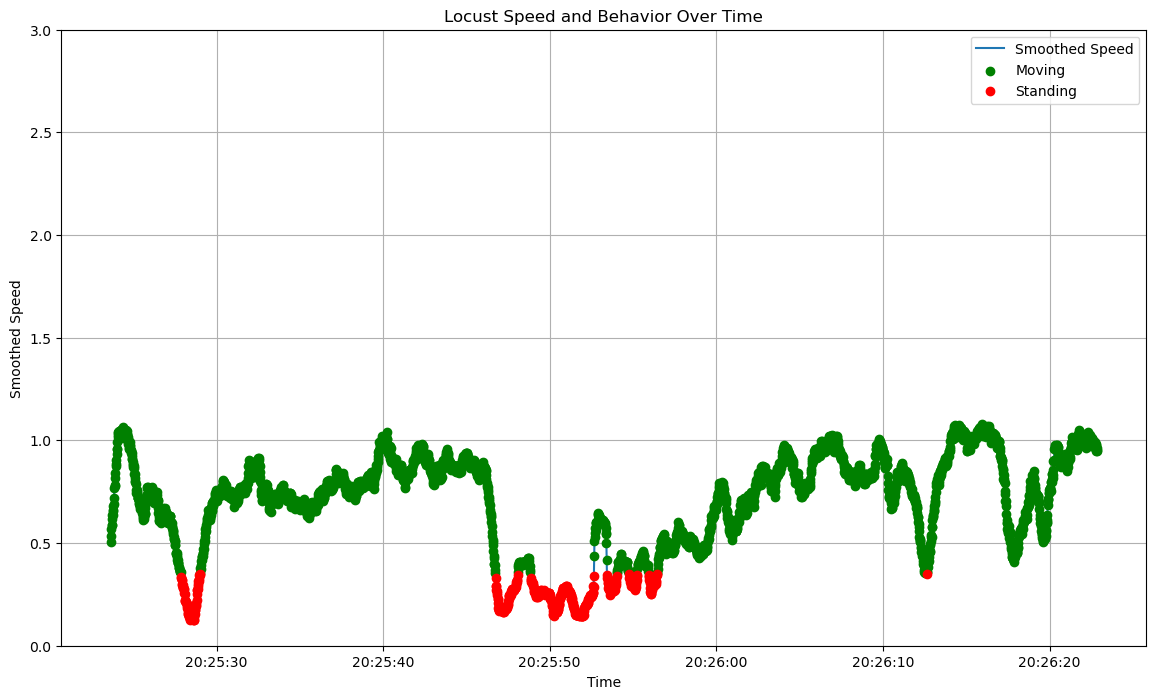

In [107]:
# Create a plot
plt.figure(figsize=(14, 8))

# Plot speed over time
plt.plot(locust_df['Current Time'], locust_df['Smoothed_Speed'], label='Smoothed Speed')

# Highlight points where the locust is moving
plt.scatter(locust_df['Current Time'][locust_df['Behavior'] == 'Moving'], 
            locust_df['Smoothed_Speed'][locust_df['Behavior'] == 'Moving'], 
            color='g', label='Moving', zorder=5)

# Highlight points where the locust is standing
plt.scatter(locust_df['Current Time'][locust_df['Behavior'] == 'Standing'], 
            locust_df['Smoothed_Speed'][locust_df['Behavior'] == 'Standing'], 
            color='r', label='Standing', zorder=5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Smoothed Speed')
plt.title('Locust Speed and Behavior Over Time')
plt.legend()
plt.grid(True)
plt.ylim([0,3])
# Show the plot
plt.show()


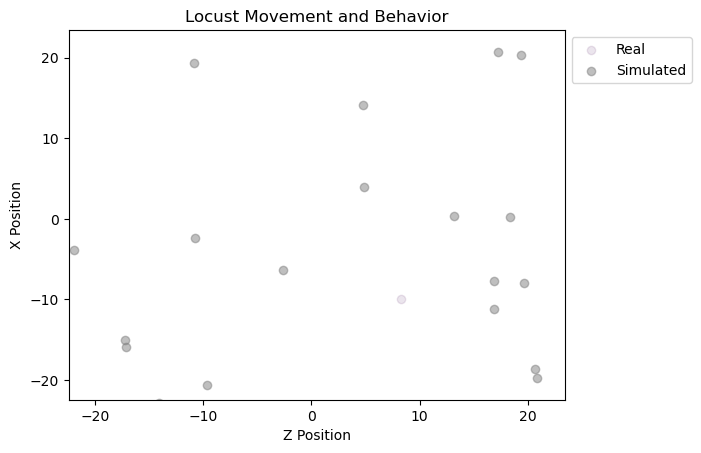

In [110]:
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Your find_closest_timestamp function
def find_closest_timestamp(real_timestamp, simulated_timestamps):
    distances = np.abs(pd.to_datetime(simulated_timestamps) - pd.to_datetime(real_timestamp))
    closest_time = simulated_timestamps.loc[distances.idxmin()]
    closest_rows = simulated_timestamps[simulated_timestamps == closest_time]
    return closest_rows.index

# Your animate function
def animate(i):
    real_data = locust_df.iloc[:i*3+1]
    x_real = real_data['InsectPosZ']
    z_real = real_data['InsectPosX']
    color_real = [1 if behavior == 'Moving' else 0 for behavior in real_data['Behavior']]
    sc_real.set_offsets(np.c_[x_real, z_real])
    sc_real.set_array(color_real)
    
    real_timestamp = real_data['Current Time'].iloc[-1]
    closest_index = find_closest_timestamp(real_timestamp, environment_df['Timestamp'])
    sim_data = environment_df.iloc[closest_index]
    x_sim = sim_data['Z']
    z_sim = sim_data['X']
    sc_sim.set_offsets(np.c_[x_sim, z_sim])
    


# Create the plot
fig, ax = plt.subplots()

# Initialize scatter plots
sc_real = ax.scatter([], [], c=[], alpha=0.1, label='Real')
sc_sim = ax.scatter([], [], c='gray', alpha=0.5, label='Simulated')

# Set labels, title, and axis limits
ax.set_xlabel('Z Position')
ax.set_ylabel('X Position')
ax.set_title('Locust Movement and Behavior')
x_min, x_max = locust_df['InsectPosX'].min(), locust_df['InsectPosX'].max()
z_min, z_max = locust_df['InsectPosZ'].min(), locust_df['InsectPosZ'].max()
ax.set_xlim(min(z_min, x_min)-10, max(z_max, x_max)+10)
ax.set_ylim(min(z_min, x_min)-10, max(z_max, x_max)+10)

# Create the animation
ani = FuncAnimation(fig, animate, frames=(len(locust_df)//3), interval=50)

# Create a writer object
writer = FFMpegWriter(fps=20)

# Save the animation
ani.save("locust_behavior_with_environment.mp4", writer=writer)
